In [1]:
import os
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch
image_size=128
batch_size = 32
class ImageFolderSplitter(Dataset):
    def __init__(self, base_dir, train_size=20, test_size=5, split='train', transform=None):
        """
        :param base_dir: Directory where all the image subfolders are located.
        :param train_size: Number of images to use for training from each folder.
        :param test_size: Number of images to use for testing from each folder.
        :param split: Either 'train' or 'test', decides which split to load.
        :param transform: Optional transform to be applied on a sample.
        """
        self.base_dir = base_dir
        self.train_size = train_size
        self.test_size = test_size
        self.split = split
        self.transform = transform

        # List all subfolders (each folder is a class)
        self.subfolders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

        self.image_paths = []
        for folder in self.subfolders:
            folder_path = os.path.join(base_dir, folder)

            # Get all image files in the current folder (assuming images are .jpg, .png, etc.)
            images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            random.shuffle(images)

            if self.split == 'train':
                selected_images = images[:self.train_size]
            elif self.split == 'test':
                selected_images = images[self.train_size:self.train_size+self.test_size]
            else:
                raise ValueError("split must be 'train' or 'test'")

            # Append the paths of selected images
            for image in selected_images:
                image_path = os.path.join(folder_path, image)
                self.image_paths.append((image_path, folder))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, label = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Set up transformations
transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),  # Resize to a smaller size for efficiency
    transforms.ToTensor(),
])

# Set up Dataset
base_dir = 'data/images/Images'  # Path to the base folder containing subfolders for classes
train_dataset = ImageFolderSplitter(base_dir=base_dir, split='train', transform=transform)
test_dataset = ImageFolderSplitter(base_dir=base_dir, split='test', transform=transform)

# Set up DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


/home/shu/.conda/envs/inf502/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 3x128x128 -> 32x64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 32x64x64 -> 64x32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 64x32x32 -> 128x16x16
            nn.ReLU(),
        )
        
        # Calculate the flattened size of the output from the encoder (feature map size)
        dummy_input = torch.zeros(1, 3, image_size,image_size)  # Batch size 1, 3 channels, 128x128 image
        with torch.no_grad():
            feature_map = self.encoder(dummy_input)  # Pass through the encoder
        flattened_size = feature_map.numel()  # Get the total number of elements in the feature map
        
        # Latent space (mu and logvar for variational distribution)
        self.fc_mu = nn.Linear(flattened_size, latent_dim)
        self.fc_logvar = nn.Linear(flattened_size, latent_dim)
        
        # Decoder
        self.fc_dec = nn.Linear(latent_dim, flattened_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x8x8 -> 64x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x16x16 -> 32x32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32x32 -> 3x64x64
            nn.Sigmoid()  # Sigmoid to get values between 0 and 1
        )
    
    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Flatten the output
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h = self.fc_dec(z)
        
        # Dynamically reshape based on flattened size
        h = h.view(h.size(0), 128, (int)(image_size/8),(int)(image_size/8))  # Adjust based on the encoder output size
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [3]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence between the learned distribution and a standard normal
    # KL = -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # The factor of 0.5 comes from integrating over the continuous space
    # where the variance is expected to be 1.
    # -0.5 * sum(1 + log(var) - mean^2 - var)
    # 'sum' reduction computes the total for the batch
    # Make sure your input images are normalized to [0, 1] to use BCE
    # If using different loss formulations like MSE, this might need adjustments
    MSE_loss = nn.MSELoss(reduction='sum')
    recon_loss = MSE_loss(recon_x.view(-1, 3 * 64 * 64), x.view(-1, 3 * 64 * 64))
    
    # Calculate KL divergence loss
    KL_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + KL_divergence


In [4]:
import torch
import torch.nn as nn

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()
        
        def down_block(in_c, out_c, normalize=True):
            layers = [nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        def up_block(in_c, out_c):
            layers = [
                nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            ]
            return nn.Sequential(*layers)

        # Encoder (Downsampling)
        self.down1 = down_block(in_channels, 64, normalize=False)  # (128x128 -> 64x64)
        self.down2 = down_block(64, 128)  # (64x64 -> 32x32)
        self.down3 = down_block(128, 256)  # (32x32 -> 16x16)
        self.down4 = down_block(256, 512)  # (16x16 -> 8x8)

        # Decoder (Upsampling)
        self.up1 = up_block(512, 256)  # (8x8 -> 16x16)
        self.up2 = up_block(512, 128)  # (16x16 -> 32x32)
        self.up3 = up_block(256, 64)  # (32x32 -> 64x64)
        self.up4 = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, x):
        # Encoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        # Decoder
        u1 = self.up1(d4)
        u1 = torch.cat((u1, d3), 1)  # Skip connection

        u2 = self.up2(u1)
        u2 = torch.cat((u2, d2), 1)

        u3 = self.up3(u2)
        u3 = torch.cat((u3, d1), 1)

        u4 = self.up4(u3)  # Final layer (64x64 -> 128x128)

        return (u4 + 1) / 2  # Normalize to [0,1]


In [5]:
# PatchGAN Discriminator
import torch
import torch.nn as nn

class PatchGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchGANDiscriminator, self).__init__()

        def block(in_c, out_c, normalize=True):
            layers = [nn.utils.spectral_norm(nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1))]
            if normalize:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.3, inplace=True))  # Slightly increased slope
            return nn.Sequential(*layers)

        self.model = nn.Sequential(
            block(in_channels * 2, 64, normalize=False),  # No normalization in first layer
            block(64, 128),
            block(128, 256),
            block(256, 512),
            nn.utils.spectral_norm(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))  # No Sigmoid
        )

    def forward(self, img_A, img_B):
        x = torch.cat((img_A, img_B), 1)  # Concatenate real & generated images
        return self.model(x)  # Output raw logits



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up dataset and dataloaders

generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)

criterion_GAN = nn.BCEWithLogitsLoss()  # Works with raw logits

criterion_L1 = nn.L1Loss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

model = VAE(latent_dim=1024).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()
# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_dataloader):
        data = data.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        recon_batch, mu, logvar = model(data)
        fake = generator(recon_batch)
        optimizer_D.zero_grad()
        res_pos=discriminator(recon_batch,data)
        res_neg=discriminator(recon_batch,fake)
        real_loss = criterion_GAN(res_pos, torch.ones_like(res_pos))
        fake_loss = criterion_GAN(res_neg, torch.zeros_like(res_neg))
        loss_D = (real_loss + fake_loss) / 2
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        recon_batch, mu, logvar = model(data)
        # print(recon_batch.shape) 
        fake = generator(recon_batch)
        optimizer_D.zero_grad()
        res_pos=discriminator(recon_batch,data)
        res_neg=discriminator(recon_batch,fake)
        fake_loss_GAN = criterion_GAN(res_neg, torch.ones_like(res_neg))
        l1_loss = criterion_L1(fake, data) * 100
        loss_G = fake_loss_GAN + l1_loss
        loss_G.backward()
        optimizer_G.step()
        # Compute the loss
        #loss = loss_function(recon_batch, data, mu, logvar)
        
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        # Backward pass
       
        
        # Update weights
        
        optimizer.step()
        
        train_loss += loss.item()
        
        if batch_idx % 5 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item()},Generator loss: {loss_G.item()}, Discriminator loss: {loss_D.item()}")

    print(f"Epoch [{epoch}/{num_epochs}] Training Loss: {train_loss / len(train_dataloader)}")

    # Test the model
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for data, _ in test_dataloader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()

    print(f"Epoch [{epoch}/{num_epochs}] Test Loss: {test_loss / len(test_dataloader)}")
    if epoch % 10 == 0:
        # Save the model checkpoints
        torch.save(model.state_dict(), f"models/vae/{epoch}.pth")
        torch.save(generator.state_dict(), f"models/gen/{epoch}.pth")
        torch.save(discriminator.state_dict(), f"models/dis/{epoch}.pth")
        print("Model saved!")
        


Epoch [0/500], Batch [0/75], Loss: 109583.2890625,Generator loss: 36.14140319824219, Discriminator loss: 0.7354209423065186
Epoch [0/500], Batch [5/75], Loss: 115630.7421875,Generator loss: 30.30503273010254, Discriminator loss: 0.8729006052017212


KeyboardInterrupt: 

In [23]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to perform the interpolation
def interpolate_and_display(model, generator,img1, img2, num_steps=10):
    # Move the model and images to the correct device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    generator.to(device)
    generator.eval()
    img1 = img1.to(device).unsqueeze(0)  # Unsqueeze to add a batch dimension
    img2 = img2.to(device).unsqueeze(0)  # Unsqueeze to add a batch dimension

    # Encode the two images to get their latent vectors
    mu1, logvar1 = model.encode(img1)
    mu2, logvar2 = model.encode(img2)

    # Reparameterize to get the latent vectors (z1 and z2)
    z1 = model.reparameterize(mu1, logvar1)
    z2 = model.reparameterize(mu2, logvar2)
    
    # Interpolate between z1 and z2
    original_interpolated_images = []
    original_interpolated_images.append(img1.cpu().detach().numpy())
    interpolated_images = []
    interpolated_images.append(img1.cpu().detach().numpy())
    for alpha in np.linspace(0, 1, num_steps):
        z_interpolated = (1 - alpha) * z1 + alpha * z2  # Linear interpolation
        recon_image = model.decode(z_interpolated)  # Decode the interpolated latent vector
        original_interpolated_images.append(recon_image.cpu().detach().numpy())
        recon_image = generator(recon_image)
        # recon_image=(recon_image+1)/2
        # recon_image = (recon_image - recon_image.min()) / (recon_image.max() - recon_image.min())

        interpolated_images.append(recon_image.cpu().detach().numpy())

    # Plot the interpolated images
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(interpolated_images[i][0], (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
        ax.axis('off')
    plt.show()
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(np.transpose(original_interpolated_images[i][0], (1, 2, 0)))  # Convert from (C, H, W) to (H, W, C)
        ax.axis('off')
    plt.show()

# Example of how to use the function after training
# Assume you have your trained model and some sample images



In [24]:
torch.save(model.state_dict(), 'vae_model_new.pth')

NameError: name 'model' is not defined

In [25]:
vae=VAE(latent_dim=1024)
vae.load_state_dict(torch.load('models/vae/30.pth'))
generator=UNetGenerator()
generator.load_state_dict(torch.load('models/gen/30.pth'))
discriminator=PatchGANDiscriminator()
discriminator.load_state_dict(torch.load('models/dis/30.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae.to(device)
vae.eval()
print(vae)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=32768, out_features=1024, bias=True)
  (fc_logvar): Linear(in_features=32768, out_features=1024, bias=True)
  (fc_dec): Linear(in_features=1024, out_features=32768, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)


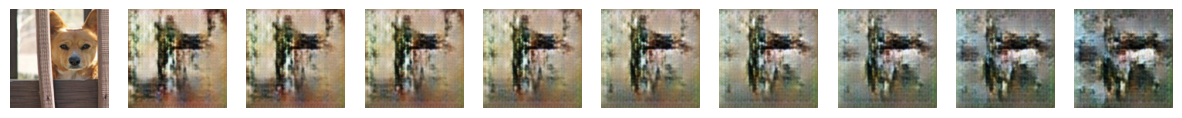

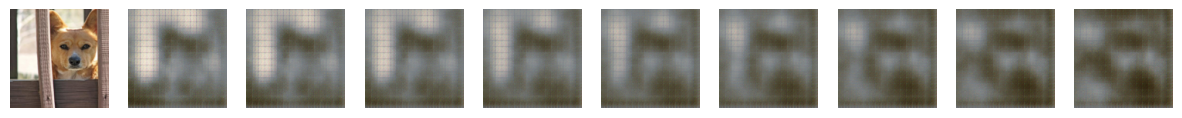

In [26]:
img1, _ = next(iter(train_dataloader))  # Example: first image from the train dataset
img2, _ = next(iter(train_dataloader))  # Example: second image from the train dataset

# Perform interpolation and display
interpolate_and_display(vae, generator,img1[0], img2[0], num_steps=10)

In [27]:
import cv2
def sharpen_image(image):
    """ Apply a simple sharpening filter to the image """
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

def denoise_image(image):
    """ Applies Non-Local Means Denoising to reduce noise. """
    return cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)  # Corrected args



In [30]:
import torch
import numpy as np

from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch.nn.functional as F
def generate_interpolated_video(model, output_folder="outputs/keyframes", output_video="outputs/output.avi", step=100, device="cuda"):
    """ Loads key frames, generates interpolated frames using VAE, and creates a video. """
    frames = []
    frame_files = sorted(os.listdir(output_folder))  # Ensure correct order

    transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),  # Resize to a smaller size for efficiency
    transforms.ToTensor(),
])

    # Load key frames
    for i in range(len(frame_files) - 1):
        img1 = Image.open(os.path.join(output_folder, frame_files[i]))
        img2 = Image.open(os.path.join(output_folder, frame_files[i + 1]))

        # Convert to tensors
        current_frame = transform(img1).unsqueeze(0).to(device)
        next_frame = transform(img2).unsqueeze(0).to(device)

        # Encode frames into latent space
        mu1, logvar1 = model.encode(current_frame)
        mu2, logvar2 = model.encode(next_frame)
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)
        # Interpolate in latent space
        for t in range(step + 1):
            alpha = t / step  # Interpolation factor
            interpolated_mu = mu1 * (1 - alpha) + mu2 * alpha
            interpolated_logvar = logvar1 * (1 - alpha) + logvar2 * alpha
            #interpolated_z = slerp(alpha, z1, z2).to(device)
            # Sample latent vector
            z = model.reparameterize(interpolated_mu, interpolated_logvar)

            # Decode to get the interpolated frame
            reconstructed_frame = model.decode(z)
            reconstructed_frame = generator(reconstructed_frame)
            # reconstructed_frame=(reconstructed_frame+1)/2
            # reconstructed_frame = (reconstructed_frame - reconstructed_frame.min()) / (reconstructed_frame.max() - reconstructed_frame.min())
            frame_np = reconstructed_frame.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
            frame_np = np.clip(frame_np * 255, 0, 255).astype(np.uint8)
            frame_np = sharpen_image(frame_np)
            # frame_np = enhance_image(frame_np)
            # plt.imshow(frame_np)
            # plt.axis('off')
            # plt.show(block=False)
            # plt.pause(0.1)
            frames.append(frame_np)

    # Save the video
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"XVID")
    out = cv2.VideoWriter(output_video, fourcc, 10, (width, height))

    for frame in frames:
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

    out.release()
    print(f"Video saved as {output_video}")

In [31]:
generate_interpolated_video(model=vae)

Video saved as outputs/output.avi
